In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os
import scipy.stats as stats

In [2]:
plt.style.use('tableau-colorblind10')

In [3]:
projdir = os.getcwd()
outdir = projdir + "/output/MonteCarlo"
plotdir = projdir + "/figures"

In [4]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/tempthresholds/figures


In [5]:
scenarios = [(2,45)]
surge_option = 2
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]

In [6]:
def subtract_ref_npv(dfO,dfG):
    nens = dfO.ens.max()
    npv_ref = np.zeros(nens)
    df1 = dfO.loc[dfO.time==1]
    for i in range(1,nens+1):
        # first 10 of the first timestep for a single ensemble member are OptimalCost
        # *10 to account for 10-year timestep vs annual costs
        npv_ref[i-1] = np.sum(np.array(df1.loc[df1.ens==i,"cost"])[:10])*10
    dfG.npv = dfG.npv - npv_ref
    return dfG

In [7]:
dfS = {scen : None for scen in scenarios} # global NPV, GMSL, temps, brick ensemble #s, 
#dfO = {scen : None for scen in scenarios} # global optimal cost, strategies for each segment

for (ssp,rcp) in scenarios:
    slrdir = outdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell/CIAM MC5000/PostProcessing"
    dfS[(ssp,rcp)] = pd.read_csv(slrdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell.csv")
    dfOG = pd.read_csv(slrdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell.csv")
    dfS[(ssp,rcp)] = subtract_ref_npv(dfOG,dfS[(ssp,rcp)])

    dfR = pd.read_csv(slrdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell.csv")
    dfOR = pd.read_csv(slrdir+"/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell.csv")
    dfR = dfR - dfOR

    dfS[(ssp,rcp)] = dfS[(ssp,rcp)].join(dfR)
    dfS[(ssp,rcp)]["scenario"] = [str(ssp)+"-"+str(rcp)]*len(dfS[(ssp,rcp)])
    

In dfOG, associated with time=10 for each ensemble member, there are 70 rows. Each set of 10 corresponds to [:OptimalCost, :OptimalStormCapital, :OptimalStormPop, :OptimalConstruct, :OptimalFlood, :OptimalRelocate, :OptimalWetland]

Optimal costs in 2100

In [8]:
dfOG.loc[(dfOG.ens==1) & (dfOG.time==10),["cost","gdp","pct_gdp"]][:10].sum()*10 - \
dfOG.loc[(dfOG.ens==1) & (dfOG.time==1),["cost","gdp","pct_gdp"]][:10].sum()*10

cost       3.511587e+03
gdp        3.669599e+07
pct_gdp    4.290351e-03
dtype: float64

Construct costs in 2100

In [9]:
dfOG.loc[(dfOG.ens==1) & (dfOG.time==10),["cost","gdp","pct_gdp"]][30:40].sum()*10 - \
dfOG.loc[(dfOG.ens==1) & (dfOG.time==1),["cost","gdp","pct_gdp"]][30:40].sum()*10

cost       2.642438e+02
gdp        3.669599e+07
pct_gdp   -1.720658e-04
dtype: float64

Flood costs in 2100

In [10]:
dfOG.loc[(dfOG.ens==1) & (dfOG.time==10),["cost","gdp","pct_gdp"]][40:50].sum()*10 - \
dfOG.loc[(dfOG.ens==1) & (dfOG.time==1),["cost","gdp","pct_gdp"]][40:50].sum()*10

cost       1.711147e+03
gdp        3.669599e+07
pct_gdp    2.068053e-03
dtype: float64

In [11]:
dfN = pd.concat([dfS[(ssp,rcp)] for (ssp,rcp) in scenarios])

<br>

---

<br>

### NPV (global) of total adaptation costs and damages, as bar graphs with error bars

Global NPV of future adaptation costs at different thresholds

In [12]:
quants = [.05,.5,.95]
#threshold_labels = ["$\leq$1.5 $^\circ$C", "1.5-2.5 $^\circ$C", "2.5-3.5 $^\circ$C", "3.5-4.5 $^\circ$C", ">4.5 $^\circ$C"]
threshold_labels = ["$\leq$1.5 $^\circ$C", "1.5-2.5 $^\circ$C", "2.5-3.5 $^\circ$C", ">3.5 $^\circ$C"]
threshold_colors = ["steelblue", "seagreen", "darkorange", "firebrick", "black"]

Heights for bar graph

In [13]:
npv_heights = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 3.5), "npv"].quantile(0.5)])

Upper and lower bounds of error bar (will need to get length for `plt.errorbar`)

In [14]:
npv_uppers  = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 3.5), "npv"].quantile(quants[-1])])
npv_lowers  = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 3.5), "npv"].quantile(quants[0])])

In [15]:
for t in range(len(threshold_labels)):
    print(threshold_labels[t], np.round(npv_heights[t]), " (",np.round(npv_lowers[t]),"-",np.round(npv_uppers[t]),")")

$\leq$1.5 $^\circ$C 1300.0  ( 1153.0 - 1489.0 )
1.5-2.5 $^\circ$C 1680.0  ( 1330.0 - 2682.0 )
2.5-3.5 $^\circ$C 2500.0  ( 1872.0 - 3138.0 )
>3.5 $^\circ$C 2935.0  ( 2411.0 - 3543.0 )


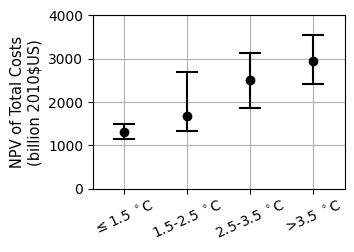

In [16]:
fig,ax = plt.subplots(1,1,figsize=(3.25,2.25))
#plt.bar(x=threshold_labels, height=npv_heights, width=0.6)
plt.errorbar(x=threshold_labels, y=npv_heights, 
             yerr=[npv_heights-npv_lowers, npv_uppers-npv_heights],
             fmt='o', color="black", elinewidth=1.5, capsize=8, capthick=1.5)
plt.axis([-0.5,3.5,0,4000]); plt.ylabel("NPV of Total Costs\n(billion 2010$US)", fontsize=10.5)
plt.xticks(rotation=24, fontsize=10); plt.yticks(fontsize=10)
plt.grid(); ax.set_axisbelow(True)
fig.savefig("./figures/npv_global_errorbars-only_Darnell.pdf", bbox_inches='tight');

### NPV (global), as histograms/kdes

In [17]:
npv_kde = [stats.gaussian_kde(dfN.loc[(dfN.temp2100 <= 1.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 3.5), "npv"])]

KDEs of GMSL

(gmsl saved as relative to 1995-2014)

In [18]:
gmsl_kde = [stats.gaussian_kde(dfN.loc[(dfN.temp2100 <= 1.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 3.5), "gmsl2100"])]

combined version (NPV + GMSL)

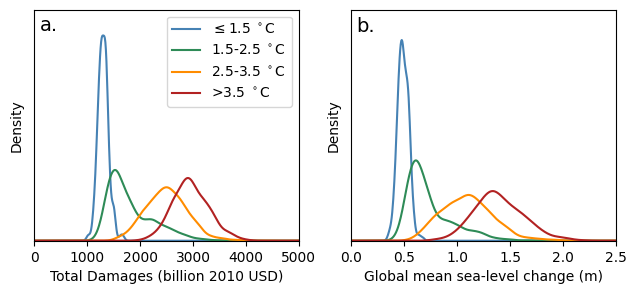

In [19]:
fig,ax = plt.subplots(1,2,figsize=(7.5,3))

# NPV
x = np.linspace(start=0, stop=5000, num=500)
for t in range(len(threshold_labels)):
    ax[0].plot(x, npv_kde[t].evaluate(x), color=threshold_colors[t], label=threshold_labels[t])
ax[0].set_xlabel("Total Damages (billion 2010 USD)"); ax[0].set_ylabel("Density"); ax[0].set_yticks([])
ax[0].legend(); ax[0].text(100,0.004,"a.",fontsize=14); ax[0].set_xlim([0,5000]); ax[0].set_ylim([0,0.0044])

# GMSL
x = np.linspace(start=0, stop=2.5, num=500)
for t in range(len(threshold_labels)):
    ax[1].plot(x, gmsl_kde[t].evaluate(x), color=threshold_colors[t], label=threshold_labels[t])
ax[1].set_xlabel("Global mean sea-level change (m)"); ax[1].set_ylabel("Density"); ax[1].set_yticks([])
ax[1].text(.05,7.5,"b.",fontsize=14); ax[1].set_xlim([0,2.5]); ax[1].set_ylim([0,8.3])
fig.savefig("./figures/npv+gmsl2100_kde_Darnell.pdf", bbox_inches='tight');

Probability of exceeding 50cm or 1m GMSL, conditioned on different temperature thresholds

In [20]:
print("P(GMSL>0.5m | GMST<1.5) =",np.round(len(dfN.loc[(dfN.temp2100 <= 1.5) & (dfN.gmsl2100>0.5)])/len(dfN.loc[(dfN.temp2100 <= 1.5)]),4))
print("P(GMSL>0.5m | 1.5<GMST<2.5) =",np.round(len(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5) & (dfN.gmsl2100>0.5)])/len(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5)]),4))
print("P(GMSL>0.5m | 2.5<GMST<3.5) =",np.round(len(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5) & (dfN.gmsl2100>0.5)])/len(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5)]),4))
print("P(GMSL>0.5m | GMST>3.5) =",np.round(len(dfN.loc[(dfN.temp2100 > 3.5) & (dfN.gmsl2100>0.5)])/len(dfN.loc[(dfN.temp2100 > 3.5)]),4))

P(GMSL>0.5m | GMST<1.5) = 0.4081
P(GMSL>0.5m | 1.5<GMST<2.5) = 0.9558
P(GMSL>0.5m | 2.5<GMST<3.5) = 1.0
P(GMSL>0.5m | GMST>3.5) = 1.0


In [21]:
print("P(GMSL>1m | GMST<1.5) =",np.round(len(dfN.loc[(dfN.temp2100 <= 1.5) & (dfN.gmsl2100>1)])/len(dfN.loc[(dfN.temp2100 <= 1.5)]),4))
print("P(GMSL>1m | 1.5<GMST<2.5) =",np.round(len(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5) & (dfN.gmsl2100>1)])/len(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5)]),4))
print("P(GMSL>1m | 2.5<GMST<3.5) =",np.round(len(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5) & (dfN.gmsl2100>1)])/len(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5)]),4))
print("P(GMSL>1m | GMST>3.5) =",np.round(len(dfN.loc[(dfN.temp2100 > 3.5) & (dfN.gmsl2100>1)])/len(dfN.loc[(dfN.temp2100 > 3.5)]),4))

P(GMSL>1m | GMST<1.5) = 0.0
P(GMSL>1m | 1.5<GMST<2.5) = 0.1317
P(GMSL>1m | 2.5<GMST<3.5) = 0.6421
P(GMSL>1m | GMST>3.5) = 0.9675


Check against Mengel et al 2018 finding that temperature stabilization below 2 deg C is insufficient to limit SLR < 2 m.

In [22]:
print("P(GMSL>1.5m | GMST<2) =",np.round(len(dfN.loc[(dfN.temp2100 <= 2) & (dfN.gmsl2100>1.5)])/len(dfN.loc[(dfN.temp2100 <= 2)]),4))

P(GMSL>1.5m | GMST<2) = 0.0


### NPV, regional breakdown as %gdp as in the example below

Adapted from code in `raddleverse/CIAM_uncertainty_propagation` (Copyright, Wong, Rennels et al). citations:
* Wong, T. (2022). CIAM uncertainty propagation experiment codes and output files (v1.0.1). Zenodo. https://doi.org/10.5281/zenodo.6835363
*  Wong, T. E., Ledna, C., Rennels, L., Sheets, H., Errickson, F. C., Diaz, D., & Anthoff, D. (2022). Sea level and socioeconomic uncertainty drives high-end coastal adaptation costs. Earth's Future, 10, e2022EF003061. https://doi.org/10.1029/2022EF003061 

https://github.com/raddleverse/CIAM_uncertainty_propagation/blob/master/work_uncertainty_propagation/plotsAndAnalysis_uncertaintyPropagation.ipynb

gdp per capita (just first year (2010), all in US$2010)

In [23]:
ypcc = {scen : pd.read_csv(projdir+"/data/ssp/ypcc_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
dfGP = {scen : pd.DataFrame() for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["rgn"] = ypcc[scen].columns[1:]
    dfGP[scen]["gdp_per_capita"] = np.array(ypcc[scen].iloc[0][1:])

population (millions)

In [24]:
pop = {scen : pd.read_csv(projdir+"/data/ssp/pop_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["pop"] = np.array(pop[scen].iloc[0][1:])

get total gdp

In [25]:
for scen in scenarios:
    dfGP[scen]["gdp"] = dfGP[scen]["gdp_per_capita"]*dfGP[scen]["pop"]*1e6/1e9 
# 1e6 since population is in units of millions
# and /1e9 to get in units of billions US$2010

mapping of segments/regions in CIAM, to the 7 World Bank regions

gdp is in units of billions US$2010, since the NPV results are also billions

In [26]:
wbsegs = pd.read_csv(projdir+"/data/segments_regions_WB.csv")
regions = list(wbsegs["global region"].unique())
rgn_gdp = {scen : {} for scen in scenarios}
for scen in scenarios:
    for rgn in regions:
        rgns_this_rgn = wbsegs.loc[wbsegs["global region"]==rgn, "regions"].unique()
        rgn_gdp[scen][rgn] = dfGP[scen].loc[dfGP[scen]["rgn"].isin(rgns_this_rgn),"gdp"].sum()

compute npv as %gdp (in 2010)

In [27]:
for scen in scenarios:
    scen_str = str(scen[0])+"-"+str(scen[1])
    for rgn in regions:
        dfN.loc[dfN.scenario==scen_str, "npv/gpd "+rgn] = 100*dfN.loc[dfN.scenario==scen_str, rgn] / \
                                                        rgn_gdp[scen][rgn]

global NPV as %GDP

In [28]:
for scen in scenarios:
    scen_str = str(scen[0])+"-"+str(scen[1])
    dfN.loc[dfN.scenario==scen_str, "npv/gpd"] = 100*dfN.loc[dfN.scenario==scen_str, "npv"] / \
                                                    np.sum(list(rgn_gdp[scen].values()))

Heights for bar graphs

In [29]:
npv_heights_rgn = {rgn : None for rgn in regions+["global"]}

for rgn in regions:
    npv_heights_rgn[rgn] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 3.5), "npv/gpd "+rgn].quantile(0.5)])
npv_heights_rgn["global"] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 3.5), "npv/gpd"].quantile(0.5)])

Upper and lower bounds of error bar (will need to get length for `plt.errorbar`)

In [30]:
npv_uppers_rgn = {rgn : None for rgn in regions+["global"]}
npv_lowers_rgn = {rgn : None for rgn in regions+["global"]}

for rgn in regions:
    npv_uppers_rgn[rgn] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 3.5), "npv/gpd "+rgn].quantile(quants[-1])])
    npv_lowers_rgn[rgn] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 3.5), "npv/gpd "+rgn].quantile(quants[0])])
npv_uppers_rgn["global"] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 3.5), "npv/gpd"].quantile(quants[-1])])
npv_lowers_rgn["global"] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 3.5), "npv/gpd"].quantile(quants[0])])

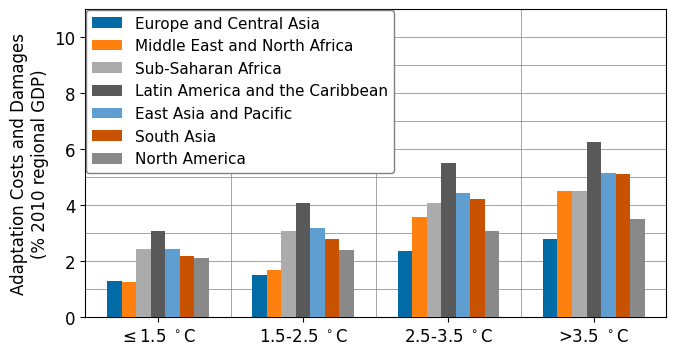

In [31]:
x = np.array([1,3,5,7])

dx = -0.6
fig,ax = plt.subplots(1,1,figsize=(7.5,4))
for w in [2,4,6,8]:
    plt.plot([w,w],[0,11],color="gray",linewidth=0.5)
for y in range(1,11):
    plt.plot([0,10],[y,y],color="gray",linewidth=0.5, zorder=0)
for r in range(len(regions)):
    plt.bar(x+dx, npv_heights_rgn[regions[r]], width=0.2, label=regions[r], zorder=3)
    dx += 0.2
plt.xlim([0,8]); plt.xticks(x, labels=threshold_labels, fontsize=12)
plt.ylim([0,11]); plt.yticks(fontsize=12)
plt.ylabel("Adaptation Costs and Damages\n(% 2010 regional GDP)", fontsize=12)
plt.legend(edgecolor="gray", framealpha=1, fontsize=11, borderaxespad=0.03)
fig.savefig("./figures/npv_regional_bar_Darnell.pdf", bbox_inches='tight');

In [32]:
print(f'{"Region":33} {"<1.5":5} {"2":4} {"3":4} {">3.5":4}')
print("-------------------------------------------------------------")
for rgn in regions+["global"]:
    hgts = npv_heights_rgn[rgn]
    print(f'{rgn:33}: {hgts[0]:0.3} {hgts[1]:0.3} {hgts[2]:0.3} {hgts[3]:0.3}')

Region                            <1.5  2    3    >3.5
-------------------------------------------------------------
Europe and Central Asia          : 1.28 1.51 2.37 2.8
Middle East and North Africa     : 1.27 1.68 3.58 4.51
Sub-Saharan Africa               : 2.45 3.07 4.07 4.52
Latin America and the Caribbean  : 3.09 4.07 5.5 6.26
East Asia and Pacific            : 2.43 3.2 4.43 5.14
South Asia                       : 2.19 2.81 4.23 5.12
North America                    : 2.1 2.4 3.08 3.51
global                           : 1.73 2.23 3.32 3.9


Increases from one temperature threshold bin to the next

In [33]:
for rgn in regions+["global"]:
    diffs = np.diff(npv_heights_rgn[rgn])
    print(f'{rgn:33}: {diffs[0]:0.3} {diffs[1]:0.3} {diffs[2]:0.3}')

Europe and Central Asia          : 0.231 0.857 0.428
Middle East and North Africa     : 0.416 1.89 0.931
Sub-Saharan Africa               : 0.611 1.01 0.446
Latin America and the Caribbean  : 0.982 1.42 0.766
East Asia and Pacific            : 0.776 1.22 0.711
South Asia                       : 0.618 1.42 0.886
North America                    : 0.298 0.679 0.428
global                           : 0.504 1.09 0.578


Total increase from <1.5 to >3.5

In [34]:
rgn_diffs = {}
for rgn in regions+["global"]:
    diffs = npv_heights_rgn[rgn][-1]-npv_heights_rgn[rgn][0]
    rgn_diffs[rgn] = diffs
    print(f'{rgn:33}: {diffs:0.3}')

Europe and Central Asia          : 1.52
Middle East and North Africa     : 3.24
Sub-Saharan Africa               : 2.07
Latin America and the Caribbean  : 3.17
East Asia and Pacific            : 2.71
South Asia                       : 2.92
North America                    : 1.41
global                           : 2.17


SSP4 experiment (below):

| region | diff |
| ------ | ---- |
| Europe and Central Asia          | 1.3 |
| Middle East and North Africa     | 2.06|
| Sub-Saharan Africa               | 1.42|
| Latin America and the Caribbean  | 2.21|
| East Asia and Pacific            | 2.14|
| South Asia                       | 1.7 |
| North America                    | 1.27|

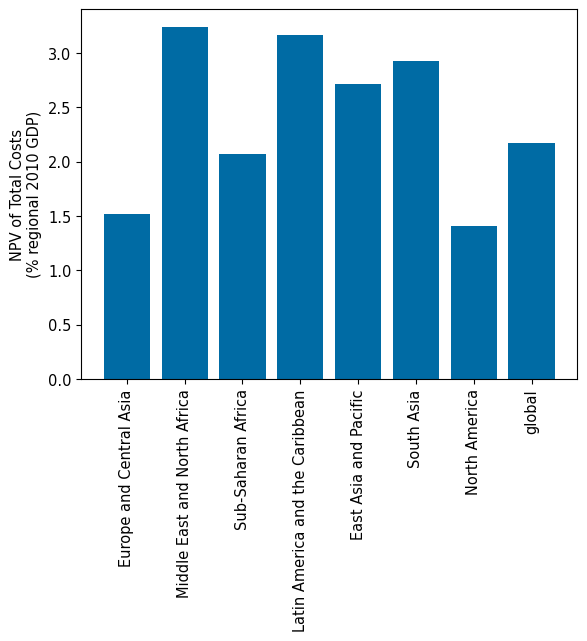

In [35]:
plt.bar(rgn_diffs.keys(), rgn_diffs.values())
#plt.axis([-0.5,3.5,0,4000])
plt.ylabel("NPV of Total Costs\n(% regional 2010 GDP)", fontsize=10.5)
plt.xticks(rotation=90, fontsize=10.5); plt.yticks(fontsize=10.5);

## How many samples in each threshold bin?

In [36]:
print(1.5,len(dfN.loc[dfN.temp2100 <= 1.5]), len(dfN.loc[dfN.temp2100 <= 1.5])/len(dfN))
for th in [2,3]:
    print(th,len(dfN.loc[abs(dfN.temp2100-th)<=0.5]), len(dfN.loc[abs(dfN.temp2100-th)<=0.5])/len(dfN))
print(3.5,len(dfN.loc[dfN.temp2100 > 3.5]), len(dfN.loc[dfN.temp2100 > 3.5])/len(dfN))

1.5 223 0.0446
2 2262 0.4524
3 2115 0.423
3.5 400 0.08


## Draw equal-sized subsets from each threshold to make sure quantiles are not sensitive to the sample sizes

In [37]:
n_samples = 223

Heights for bar graph

In [38]:
dfN.loc[(dfN.temp2100 <= 1.5),"npv"].sample(n=n_samples).quantile(0.5)

1300.063434543334

In [39]:
npv_heights_check = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].sample(n=n_samples).quantile(0.5),
                              dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].sample(n=n_samples).quantile(0.5),
                              dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].sample(n=n_samples).quantile(0.5),
                              dfN.loc[(dfN.temp2100 > 3.5), "npv"].sample(n=n_samples).quantile(0.5)])

Upper and lower bounds of error bar (will need to get length for `plt.errorbar`)

In [40]:
npv_uppers_check  = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].sample(n=n_samples).quantile(quants[-1]),
                              dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].sample(n=n_samples).quantile(quants[-1]),
                              dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].sample(n=n_samples).quantile(quants[-1]),
                              dfN.loc[(dfN.temp2100 > 3.5), "npv"].sample(n=n_samples).quantile(quants[-1])])
npv_lowers_check  = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].sample(n=n_samples).quantile(quants[0]),
                              dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].sample(n=n_samples).quantile(quants[0]),
                              dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].sample(n=n_samples).quantile(quants[0]),
                              dfN.loc[(dfN.temp2100 > 3.5), "npv"].sample(n=n_samples).quantile(quants[0])])

In [41]:
# ORIGINAL
for t in range(len(threshold_labels)):
    print(threshold_labels[t], np.round(npv_heights[t]), " (",np.round(npv_lowers[t]),"-",np.round(npv_uppers[t]),")")
print("")
# EQUAL SUBSAMPLES
for t in range(len(threshold_labels)):
    print(threshold_labels[t], np.round(npv_heights_check[t]), " (",np.round(npv_lowers_check[t]),"-",np.round(npv_uppers_check[t]),")")

$\leq$1.5 $^\circ$C 1300.0  ( 1153.0 - 1489.0 )
1.5-2.5 $^\circ$C 1680.0  ( 1330.0 - 2682.0 )
2.5-3.5 $^\circ$C 2500.0  ( 1872.0 - 3138.0 )
>3.5 $^\circ$C 2935.0  ( 2411.0 - 3543.0 )

$\leq$1.5 $^\circ$C 1300.0  ( 1153.0 - 1489.0 )
1.5-2.5 $^\circ$C 1694.0  ( 1305.0 - 2718.0 )
2.5-3.5 $^\circ$C 2550.0  ( 1829.0 - 3146.0 )
>3.5 $^\circ$C 2913.0  ( 2456.0 - 3536.0 )


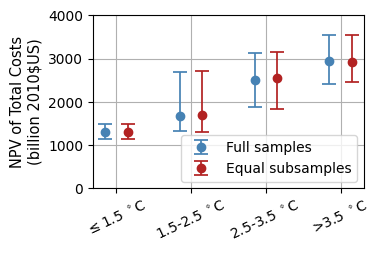

In [42]:
x = np.arange(start=0, stop=4, step=1)
dx = 0.15

fig,ax = plt.subplots(1,1,figsize=(3.5,2.25))
#plt.bar(x=x-dx, height=npv_heights, label="Full samples", width=0.3)
plt.errorbar(x=x-dx, y=npv_heights, label="Full samples",
             yerr=[npv_heights-npv_lowers, npv_uppers-npv_heights],
             fmt='o', color="steelblue", elinewidth=1.25, capsize=5, capthick=1.25)
#plt.bar(x=x+dx, height=npv_heights_check, label="Equal subsamples", width=0.3, color="seagreen")
plt.errorbar(x=x+dx, y=npv_heights_check, label="Equal subsamples",
             yerr=[npv_heights_check-npv_lowers_check, npv_uppers_check-npv_heights_check],
             fmt='o', color="firebrick", elinewidth=1.25, capsize=5, capthick=1.25)
plt.ylim([0,4000]); plt.ylabel("NPV of Total Costs\n(billion 2010$US)", fontsize=10.5)
plt.xticks(ticks=x, labels=threshold_labels, rotation=25, fontsize=10); plt.yticks(fontsize=10)
plt.grid(); ax.set_axisbelow(True); plt.legend()
fig.savefig("./figures/npv_global_errorbars-only_check_subsample_Darnell.pdf", bbox_inches='tight');

## Draw a subset from overall ensemble to make sure quantiles are not sensitive to the overall ensemble size

In [43]:
n_ensemble = 4000
dfN2 = dfN.sample(n=n_ensemble, replace=False)

In [44]:
npv_heights_check2 = np.array([dfN2.loc[(dfN2.temp2100 <= 1.5), "npv"].quantile(0.5),
                               dfN2.loc[(dfN2.temp2100 > 1.5) & (dfN2.temp2100 <= 2.5), "npv"].quantile(0.5),
                               dfN2.loc[(dfN2.temp2100 > 2.5) & (dfN2.temp2100 <= 3.5), "npv"].quantile(0.5),
                               dfN2.loc[(dfN2.temp2100 > 3.5), "npv"].quantile(0.5)])

Upper and lower bounds of error bar (will need to get length for `plt.errorbar`)

In [45]:
npv_uppers_check2  = np.array([dfN2.loc[(dfN2.temp2100 <= 1.5), "npv"].quantile(quants[-1]),
                               dfN2.loc[(dfN2.temp2100 > 1.5) & (dfN2.temp2100 <= 2.5), "npv"].quantile(quants[-1]),
                               dfN2.loc[(dfN2.temp2100 > 2.5) & (dfN2.temp2100 <= 3.5), "npv"].quantile(quants[-1]),
                               dfN2.loc[(dfN2.temp2100 > 3.5), "npv"].quantile(quants[-1])])
npv_lowers_check2  = np.array([dfN2.loc[(dfN2.temp2100 <= 1.5), "npv"].quantile(quants[0]),
                               dfN2.loc[(dfN2.temp2100 > 1.5) & (dfN2.temp2100 <= 2.5), "npv"].quantile(quants[0]),
                               dfN2.loc[(dfN2.temp2100 > 2.5) & (dfN2.temp2100 <= 3.5), "npv"].quantile(quants[0]),
                               dfN2.loc[(dfN2.temp2100 > 3.5), "npv"].quantile(quants[0])])

In [46]:
# ORIGINAL
for t in range(len(threshold_labels)):
    print(threshold_labels[t], np.round(npv_heights[t]), " (",np.round(npv_lowers[t]),"-",np.round(npv_uppers[t]),")")
print("")
# EQUAL SUBSAMPLES
for t in range(len(threshold_labels)):
    print(threshold_labels[t], np.round(npv_heights_check2[t]), " (",np.round(npv_lowers_check2[t]),"-",np.round(npv_uppers_check2[t]),")")

$\leq$1.5 $^\circ$C 1300.0  ( 1153.0 - 1489.0 )
1.5-2.5 $^\circ$C 1680.0  ( 1330.0 - 2682.0 )
2.5-3.5 $^\circ$C 2500.0  ( 1872.0 - 3138.0 )
>3.5 $^\circ$C 2935.0  ( 2411.0 - 3543.0 )

$\leq$1.5 $^\circ$C 1291.0  ( 1145.0 - 1458.0 )
1.5-2.5 $^\circ$C 1676.0  ( 1330.0 - 2696.0 )
2.5-3.5 $^\circ$C 2500.0  ( 1874.0 - 3135.0 )
>3.5 $^\circ$C 2936.0  ( 2396.0 - 3566.0 )


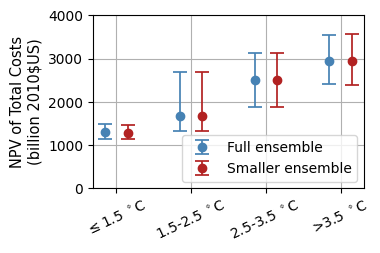

In [47]:
x = np.arange(start=0, stop=4, step=1)
dx = 0.15

fig,ax = plt.subplots(1,1,figsize=(3.5,2.25))
plt.errorbar(x=x-dx, y=npv_heights, label="Full ensemble",
             yerr=[npv_heights-npv_lowers, npv_uppers-npv_heights],
             fmt='o', color="steelblue", elinewidth=1.25, capsize=5, capthick=1.25)
plt.errorbar(x=x+dx, y=npv_heights_check2, label="Smaller ensemble",
             yerr=[npv_heights_check2-npv_lowers_check2, npv_uppers_check2-npv_heights_check2],
             fmt='o', color="firebrick", elinewidth=1.25, capsize=5, capthick=1.25)
plt.ylim([0,4000]); plt.ylabel("NPV of Total Costs\n(billion 2010$US)", fontsize=10.5)
plt.xticks(ticks=x, labels=threshold_labels, rotation=25, fontsize=10); plt.yticks(fontsize=10)
plt.grid(); ax.set_axisbelow(True); plt.legend()
fig.savefig("./figures/npv_global_errorbars-only_check_smallerensemble_Darnell.pdf", bbox_inches='tight');

### Supplemental experiment - using SSP4 as the baseline scenario

Read in the NPV data for the experiment

In [71]:
scenarios = [(4,60)]

dfS4 = {scen : None for scen in scenarios} # global NPV, GMSL, temps, brick ensemble #s, 

for (ssp,rcp) in scenarios:
    slrdir2 = outdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell/CIAM MC5000/PostProcessing"
    dfS4[(ssp,rcp)] = pd.read_csv(slrdir2+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell.csv")
    dfO4 = pd.read_csv(slrdir2+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell.csv")
    dfS4[(ssp,rcp)] = subtract_ref_npv(dfO4,dfS4[(ssp,rcp)])

    dfR4 = pd.read_csv(slrdir2+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell.csv")
    dfO4 = pd.read_csv(slrdir2+"/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s2_global_varySLR-Darnell.csv")
    dfR4 = dfR4 - dfO4

    dfS4[(ssp,rcp)] = dfS4[(ssp,rcp)].join(dfR4)
    dfS4[(ssp,rcp)]["scenario"] = [str(ssp)+"-"+str(rcp)]*len(dfS4[(ssp,rcp)])
    
dfN4 = pd.concat([dfS4[(ssp,rcp)] for (ssp,rcp) in scenarios])

Compute the NPV heights and error bars for the comparison plot

In [72]:
npv_heights2 = np.array([dfN4.loc[(dfN4.temp2100 <= 1.5), "npv"].quantile(0.5),
                         dfN4.loc[(dfN4.temp2100 > 1.5) & (dfN4.temp2100 <= 2.5), "npv"].quantile(0.5),
                         dfN4.loc[(dfN4.temp2100 > 2.5) & (dfN4.temp2100 <= 3.5), "npv"].quantile(0.5),
                         dfN4.loc[(dfN4.temp2100 > 3.5), "npv"].quantile(0.5)])
npv_uppers2  = np.array([dfN4.loc[(dfN4.temp2100 <= 1.5), "npv"].quantile(quants[-1]),
                         dfN4.loc[(dfN4.temp2100 > 1.5) & (dfN4.temp2100 <= 2.5), "npv"].quantile(quants[-1]),
                         dfN4.loc[(dfN4.temp2100 > 2.5) & (dfN4.temp2100 <= 3.5), "npv"].quantile(quants[-1]),
                         dfN4.loc[(dfN4.temp2100 > 3.5), "npv"].quantile(quants[-1])])
npv_lowers2  = np.array([dfN4.loc[(dfN4.temp2100 <= 1.5), "npv"].quantile(quants[0]),
                         dfN4.loc[(dfN4.temp2100 > 1.5) & (dfN4.temp2100 <= 2.5), "npv"].quantile(quants[0]),
                         dfN4.loc[(dfN4.temp2100 > 2.5) & (dfN4.temp2100 <= 3.5), "npv"].quantile(quants[0]),
                         dfN4.loc[(dfN4.temp2100 > 3.5), "npv"].quantile(quants[0])])
for t in range(len(threshold_labels)):
    print(threshold_labels[t], np.round(npv_heights2[t]), " (",np.round(npv_lowers2[t]),"-",np.round(npv_uppers2[t]),")")

$\leq$1.5 $^\circ$C 1184.0  ( 1033.0 - 1337.0 )
1.5-2.5 $^\circ$C 1501.0  ( 1199.0 - 2339.0 )
2.5-3.5 $^\circ$C 2143.0  ( 1613.0 - 2703.0 )
>3.5 $^\circ$C 2569.0  ( 2150.0 - 3119.0 )


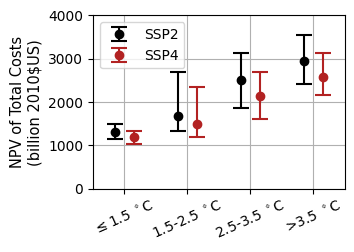

In [73]:
fig,ax = plt.subplots(1,1,figsize=(3.25,2.25))
plt.errorbar(x=[-.15,.85,1.85,2.85], y=npv_heights, 
             yerr=[npv_heights-npv_lowers, npv_uppers-npv_heights],
             fmt='o', color="black", elinewidth=1.5, capsize=6, capthick=1.5, label="SSP2")
plt.errorbar(x=[.15,1.15,2.15,3.15], y=npv_heights2, 
             yerr=[npv_heights2-npv_lowers2, npv_uppers2-npv_heights2],
             fmt='o', color="firebrick", elinewidth=1.5, capsize=6, capthick=1.5, label="SSP4")
plt.axis([-0.5,3.5,0,4000]); plt.ylabel("NPV of Total Costs\n(billion 2010$US)", fontsize=10.5)
plt.xticks(ticks=[0,1,2,3], labels=threshold_labels, rotation=24, fontsize=10); plt.yticks(fontsize=10)
plt.grid(); ax.set_axisbelow(True); plt.legend()
fig.savefig("./figures/npv_global_errorbars-only_Darnell_SOM-SSP2v4.pdf", bbox_inches='tight');

#### Regional breakdown

Get GDP and population info

In [51]:
ypcc = {scen : pd.read_csv(projdir+"/data/ssp/ypcc_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
dfGP = {scen : pd.DataFrame() for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["rgn"] = ypcc[scen].columns[1:]
    dfGP[scen]["gdp_per_capita"] = np.array(ypcc[scen].iloc[0][1:])

pop = {scen : pd.read_csv(projdir+"/data/ssp/pop_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["pop"] = np.array(pop[scen].iloc[0][1:])

for scen in scenarios:
    dfGP[scen]["gdp"] = dfGP[scen]["gdp_per_capita"]*dfGP[scen]["pop"]*1e6/1e9 

rgn_gdp = {scen : {} for scen in scenarios}
for scen in scenarios:
    for rgn in regions:
        rgns_this_rgn = wbsegs.loc[wbsegs["global region"]==rgn, "regions"].unique()
        rgn_gdp[scen][rgn] = dfGP[scen].loc[dfGP[scen]["rgn"].isin(rgns_this_rgn),"gdp"].sum()

for scen in scenarios:
    scen_str = str(scen[0])+"-"+str(scen[1])
    for rgn in regions:
        dfN4.loc[dfN4.scenario==scen_str, "npv/gpd "+rgn] = 100*dfN4.loc[dfN4.scenario==scen_str, rgn] / \
                                                            rgn_gdp[scen][rgn]
        
for scen in scenarios:
    scen_str = str(scen[0])+"-"+str(scen[1])
    dfN4.loc[dfN4.scenario==scen_str, "npv/gpd"] = 100*dfN4.loc[dfN4.scenario==scen_str, "npv"] / \
                                                     np.sum(list(rgn_gdp[scen].values()))

Compute bar heights

In [52]:
npv_heights_rgn4 = {rgn : None for rgn in regions+["global"]}

for rgn in regions:
    npv_heights_rgn4[rgn] = np.array([dfN4.loc[(dfN4.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(0.5),
                                      dfN4.loc[(dfN4.temp2100 > 1.5) & (dfN4.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(0.5),
                                      dfN4.loc[(dfN4.temp2100 > 2.5) & (dfN4.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(0.5),
                                      dfN4.loc[(dfN4.temp2100 > 3.5), "npv/gpd "+rgn].quantile(0.5)])
npv_heights_rgn4["global"] = np.array([dfN4.loc[(dfN4.temp2100 <= 1.5), "npv/gpd"].quantile(0.5),
                                       dfN4.loc[(dfN4.temp2100 > 1.5) & (dfN4.temp2100 <= 2.5), "npv/gpd"].quantile(0.5),
                                       dfN4.loc[(dfN4.temp2100 > 2.5) & (dfN4.temp2100 <= 3.5), "npv/gpd"].quantile(0.5),
                                       dfN4.loc[(dfN4.temp2100 > 3.5), "npv/gpd"].quantile(0.5)])

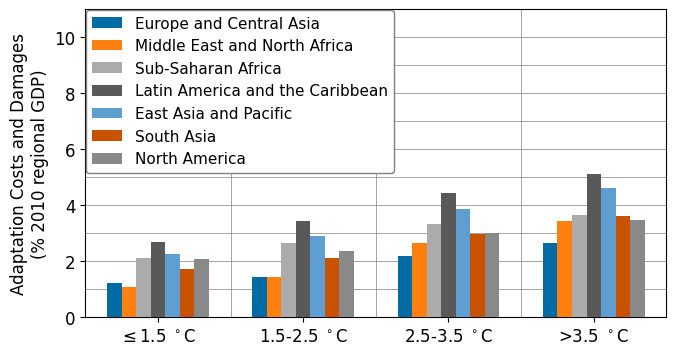

In [53]:
x = np.array([1,3,5,7])

dx = -0.6
fig,ax = plt.subplots(1,1,figsize=(7.5,4))
for w in [2,4,6,8]:
    plt.plot([w,w],[0,11],color="gray",linewidth=0.5)
for y in range(1,11):
    plt.plot([0,10],[y,y],color="gray",linewidth=0.5, zorder=0)
for r in range(len(regions)):
    plt.bar(x+dx, npv_heights_rgn4[regions[r]], width=0.2, label=regions[r], zorder=3)
    dx += 0.2
plt.xlim([0,8]); plt.xticks(x, labels=threshold_labels, fontsize=12)
plt.ylim([0,11]); plt.yticks(fontsize=12)
plt.ylabel("Adaptation Costs and Damages\n(% 2010 regional GDP)", fontsize=12)
plt.legend(edgecolor="gray", framealpha=1, fontsize=11, borderaxespad=0.03, loc="upper left")#plt.legend(frameon=False)
#plt.grid(); ax.set_axisbelow(True)
fig.savefig("./figures/npv_regional_bar_Darnell_SOM-SSP4.pdf", bbox_inches='tight');

Difference in SSP4 relative to SSP2 (4 minus 2)

In [54]:
print(f'{"Region":33} {"<1.5":5} {"2":4} {"3":4} {">3.5":4}')
print("-------------------------------------------------------------")
for rgn in regions:
    hgts = npv_heights_rgn4[rgn] - npv_heights_rgn[rgn]
    print(f'{rgn:33}: {hgts[0]:0.3} {hgts[1]:0.3} {hgts[2]:0.3} {hgts[3]:0.3}')

Region                            <1.5  2    3    >3.5
-------------------------------------------------------------
Europe and Central Asia          : -0.0518 -0.0617 -0.166 -0.161
Middle East and North Africa     : -0.181 -0.261 -0.941 -1.09
Sub-Saharan Africa               : -0.322 -0.398 -0.755 -0.859
Latin America and the Caribbean  : -0.398 -0.629 -1.07 -1.14
East Asia and Pacific            : -0.177 -0.291 -0.546 -0.535
South Asia                       : -0.481 -0.696 -1.26 -1.49
North America                    : -0.0158 -0.0242 -0.0609 -0.0265


Raw heights for the bars in the figure above

In [55]:
print(f'{"Region":33} {"<1.5":5} {"2":4} {"3":4} {">3.5":4}')
print("-------------------------------------------------------------")
for rgn in regions:
    hgts = npv_heights_rgn4[rgn]
    print(f'{rgn:33}: {hgts[0]:0.3} {hgts[1]:0.3} {hgts[2]:0.3} {hgts[3]:0.3}')

Region                            <1.5  2    3    >3.5
-------------------------------------------------------------
Europe and Central Asia          : 1.23 1.45 2.21 2.64
Middle East and North Africa     : 1.09 1.42 2.64 3.42
Sub-Saharan Africa               : 2.13 2.67 3.32 3.66
Latin America and the Caribbean  : 2.69 3.45 4.43 5.12
East Asia and Pacific            : 2.25 2.91 3.88 4.6
South Asia                       : 1.71 2.12 2.97 3.62
North America                    : 2.09 2.38 3.02 3.48


Changes from one temperature bin to the next

In [56]:
print(f'{"Region":33} {"<1.5 - 2":5} {"2 - 3":4} {"3 - >3.5":4}')
print("-------------------------------------------------------------")
for rgn in regions:
    hgts = npv_heights_rgn4[rgn][1:] - npv_heights_rgn4[rgn][:-1]
    print(f'{rgn:33}: {hgts[0]:0.3} {hgts[1]:0.3} {hgts[2]:0.3}')

Region                            <1.5 - 2 2 - 3 3 - >3.5
-------------------------------------------------------------
Europe and Central Asia          : 0.221 0.753 0.433
Middle East and North Africa     : 0.335 1.21 0.785
Sub-Saharan Africa               : 0.535 0.652 0.341
Latin America and the Caribbean  : 0.751 0.982 0.697
East Asia and Pacific            : 0.662 0.97 0.722
South Asia                       : 0.403 0.855 0.651
North America                    : 0.29 0.643 0.463


In [57]:
rgn_diffs = {}
for rgn in regions:
    diffs = npv_heights_rgn4[rgn][-1]-npv_heights_rgn4[rgn][0]
    rgn_diffs[rgn] = diffs
    print(f'{rgn:33}: {diffs:0.3}')

Europe and Central Asia          : 1.41
Middle East and North Africa     : 2.33
Sub-Saharan Africa               : 1.53
Latin America and the Caribbean  : 2.43
East Asia and Pacific            : 2.35
South Asia                       : 1.91
North America                    : 1.4


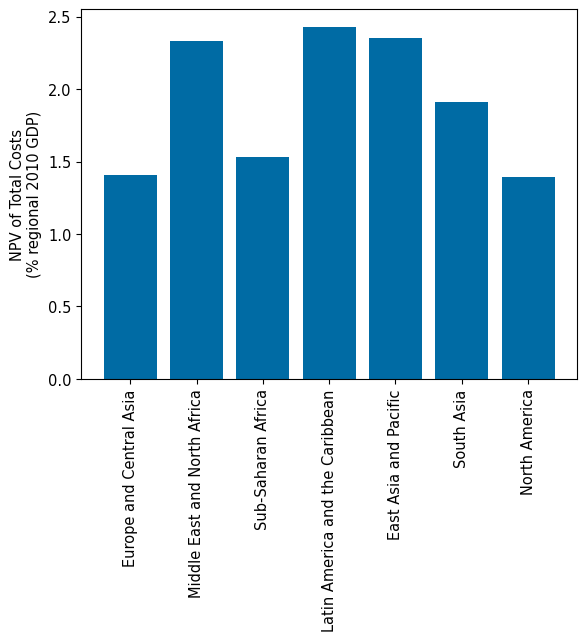

In [58]:
plt.bar(rgn_diffs.keys(), rgn_diffs.values())
#plt.axis([-0.5,3.5,0,4000])
plt.ylabel("NPV of Total Costs\n(% regional 2010 GDP)", fontsize=10.5)
plt.xticks(rotation=90, fontsize=10.5); plt.yticks(fontsize=10.5);

## update/check based on new results

Little change in Europe and Central Asia and North America.

Largest changes in Latin American and the Caribbean and in South Asia.

Attributable to much larger change in GDP for these regions
* eg, South Asia sees about -70 (US$T, out of 90) vs North America sees about -25 (out of 70)
* or Europe and Central Asia with -25 (out of 80), vs Latin America and Caribbean at about -20 (out of 40)

GDP tied to damages
* VSL depends on segment-level GDP
* capital stock valuation too, which affects relocation costs and storm damages

Also have lower population all around, but as a proportion of SSP2 levels, South Asia and Latin American/Caribbean see a lower relative population in SSP4 compared to SSP2, vs Europe/Central Asia and North America (eg)

So while GDP decreases, which all other things being equal would make NPV as a % of GDP increase, the lower valuation of both human and property losses leads to overall lower damages as a % of GDP. These results should not be taken as a sign of lower inequality in damages under SSP4 (particularly given the SSP4 storyline being one of inequality within and across countries)

#### Plots of GDP, pop, GDP/pop vs difference in 2-deg 3-deg damages as %GDP for both SSP2 and SSP4

dfN4 and dfN are the NPV

modifying to get full time series and not just the first time point. or just year 2100 or something

In [59]:
scenarios = [(2,45),(4,60)]

ypcc = {scen : pd.read_csv(projdir+"/data/ssp/ypcc_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
dfGP = {scen : pd.DataFrame() for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["rgn"] = ypcc[scen].columns[1:]
    dfGP[scen]["gdp_per_capita"] = np.array(ypcc[scen].iloc[10][1:]) # grabbing 2100

pop = {scen : pd.read_csv(projdir+"/data/ssp/pop_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["pop"] = np.array(pop[scen].iloc[10][1:]) # grabbing 2100

for scen in scenarios:
    dfGP[scen]["gdp"] = dfGP[scen]["gdp_per_capita"]*dfGP[scen]["pop"]*1e6/1e9 

rgn_gdp = {scen : {} for scen in scenarios}
rgn_pop = {scen : {} for scen in scenarios}
for scen in scenarios:
    for rgn in regions:
        rgns_this_rgn = wbsegs.loc[wbsegs["global region"]==rgn, "regions"].unique()
        rgn_gdp[scen][rgn] = dfGP[scen].loc[dfGP[scen]["rgn"].isin(rgns_this_rgn),"gdp"].sum()
        rgn_pop[scen][rgn] = dfGP[scen].loc[dfGP[scen]["rgn"].isin(rgns_this_rgn),"pop"].sum()

In [60]:
rgn_gdp_l = {scen : np.array([rgn_gdp[scen][r] for r in regions]) for scen in scenarios}
rgn_pop_l = {scen : np.array([rgn_pop[scen][r] for r in regions]) for scen in scenarios}
rgn_gdppop_l = {scen : np.array([rgn_gdp[scen][r]/rgn_pop[scen][r] for r in regions]) for scen in scenarios}
dt23 = {(2,45) : np.array([np.diff(npv_heights_rgn[r][1:3])[0] for r in regions]),
        (4,60) : np.array([np.diff(npv_heights_rgn4[r][1:3])[0] for r in regions])}


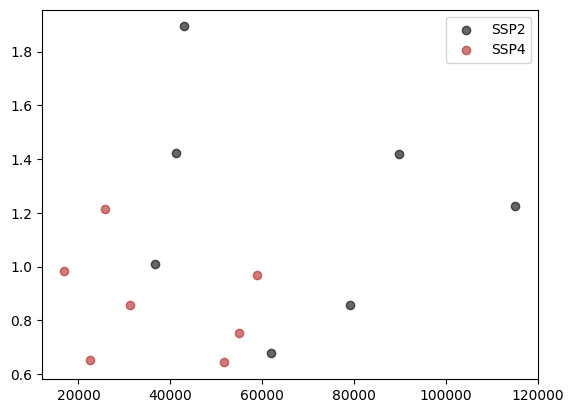

In [61]:
scen = (2,45)
plt.scatter(rgn_gdp_l[scen], dt23[scen], color="black", alpha=0.6, label="SSP2")
scen = (4,60)
plt.scatter(rgn_gdp_l[scen], dt23[scen], color="firebrick", alpha=0.6, label="SSP4")
plt.legend();

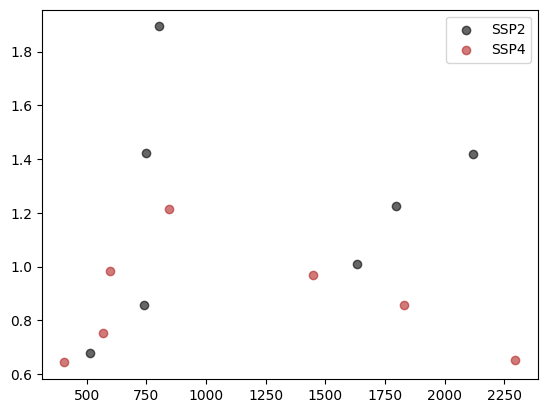

In [62]:
scen = (2,45)
plt.scatter(rgn_pop_l[scen], dt23[scen], color="black", alpha=0.6, label="SSP2")
scen = (4,60)
plt.scatter(rgn_pop_l[scen], dt23[scen], color="firebrick", alpha=0.6, label="SSP4")
plt.legend();

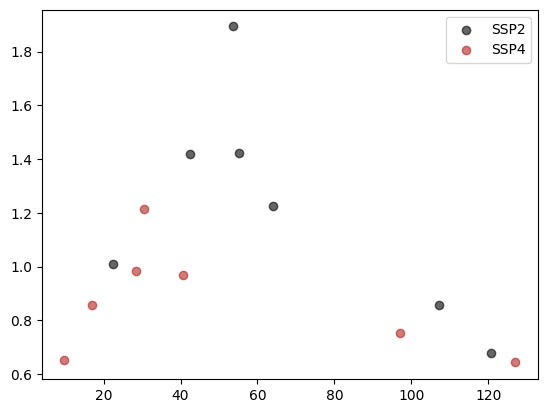

In [63]:
scen = (2,45)
plt.scatter(rgn_gdppop_l[scen], dt23[scen], color="black", alpha=0.6, label="SSP2")
scen = (4,60)
plt.scatter(rgn_gdppop_l[scen], dt23[scen], color="firebrick", alpha=0.6, label="SSP4")
plt.legend();

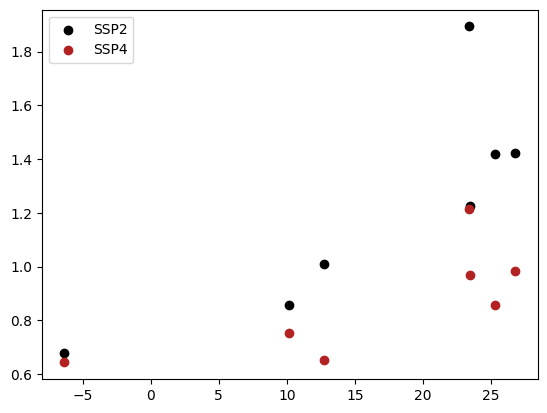

In [64]:
scen = (2,45)
plt.scatter(rgn_gdppop_l[(2,45)]-rgn_gdppop_l[(4,60)], dt23[scen], color="black", label="SSP2")
scen = (4,60)
plt.scatter(rgn_gdppop_l[(2,45)]-rgn_gdppop_l[(4,60)], dt23[scen], color="firebrick", label="SSP4")
plt.legend();

In [65]:
print(rgn_gdppop_l[(2,45)]-rgn_gdppop_l[(4,60)])
print(regions)

[10.16814521 23.35224349 12.70694169 26.78169467 23.42344515 25.30612494
 -6.3382297 ]
['Europe and Central Asia', 'Middle East and North Africa', 'Sub-Saharan Africa', 'Latin America and the Caribbean', 'East Asia and Pacific', 'South Asia', 'North America']


The larger the reduction in GDP/POP between SSP2 and SSP4, the higher the jump in damages. The regional inequalities represented by SSP4 (vs SSP2) are exacerbated by coastal damages

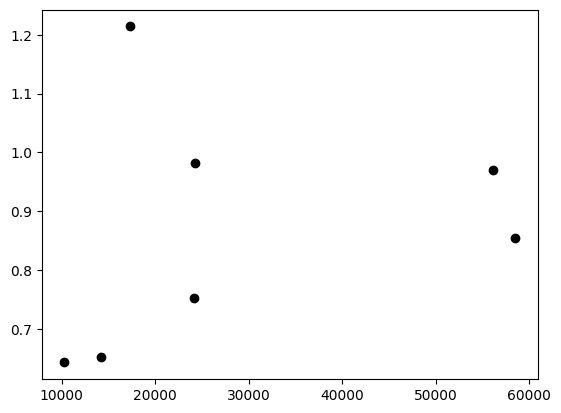

In [66]:
plt.scatter(rgn_gdp_l[(2,45)]-rgn_gdp_l[(4,60)], dt23[scen], color="black")

### Supplemental Experiment using older DINAS-COAST surge exposure data set

To characterize uncertainty from surge exposure data

Read in the NPV data for the experiment

In [67]:
scenarios = [(2,45)]

dfS2 = {scen : None for scen in scenarios} # global NPV, GMSL, temps, brick ensemble #s, 
#dfO = {scen : None for scen in scenarios} # global optimal cost, strategies for each segment

for (ssp,rcp) in scenarios:
    slrdir2 = outdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s0_global_varySLR-Darnell/CIAM MC5000/PostProcessing"
    dfS2[(ssp,rcp)] = pd.read_csv(slrdir2+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s0_global_varySLR-Darnell.csv")
    dfO2 = pd.read_csv(slrdir2+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s0_global_varySLR-Darnell.csv")
    dfS2[(ssp,rcp)] = subtract_ref_npv(dfO2,dfS2[(ssp,rcp)])

    dfR2 = pd.read_csv(slrdir2+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s0_global_varySLR-Darnell.csv")
    dfO2 = pd.read_csv(slrdir2+"/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_s0_global_varySLR-Darnell.csv")
    dfR2 = dfR2 - dfO2

    dfS2[(ssp,rcp)] = dfS2[(ssp,rcp)].join(dfR2)
    dfS2[(ssp,rcp)]["scenario"] = [str(ssp)+"-"+str(rcp)]*len(dfS2[(ssp,rcp)])
    
dfN2 = pd.concat([dfS2[(ssp,rcp)] for (ssp,rcp) in scenarios])

Compute the NPV heights and error bars for the comparison plot

In [68]:
npv_heights2 = np.array([dfN2.loc[(dfN2.temp2100 <= 1.5), "npv"].quantile(0.5),
                         dfN2.loc[(dfN2.temp2100 > 1.5) & (dfN2.temp2100 <= 2.5), "npv"].quantile(0.5),
                         dfN2.loc[(dfN2.temp2100 > 2.5) & (dfN2.temp2100 <= 3.5), "npv"].quantile(0.5),
                         dfN2.loc[(dfN2.temp2100 > 3.5), "npv"].quantile(0.5)])
npv_uppers2  = np.array([dfN2.loc[(dfN2.temp2100 <= 1.5), "npv"].quantile(quants[-1]),
                         dfN2.loc[(dfN2.temp2100 > 1.5) & (dfN2.temp2100 <= 2.5), "npv"].quantile(quants[-1]),
                         dfN2.loc[(dfN2.temp2100 > 2.5) & (dfN2.temp2100 <= 3.5), "npv"].quantile(quants[-1]),
                         dfN2.loc[(dfN2.temp2100 > 3.5), "npv"].quantile(quants[-1])])
npv_lowers2  = np.array([dfN2.loc[(dfN2.temp2100 <= 1.5), "npv"].quantile(quants[0]),
                         dfN2.loc[(dfN2.temp2100 > 1.5) & (dfN2.temp2100 <= 2.5), "npv"].quantile(quants[0]),
                         dfN2.loc[(dfN2.temp2100 > 2.5) & (dfN2.temp2100 <= 3.5), "npv"].quantile(quants[0]),
                         dfN2.loc[(dfN2.temp2100 > 3.5), "npv"].quantile(quants[0])])
for t in range(len(threshold_labels)):
    print(threshold_labels[t], np.round(npv_heights2[t]), " (",np.round(npv_lowers2[t]),"-",np.round(npv_uppers2[t]),")")

$\leq$1.5 $^\circ$C 1239.0  ( 1077.0 - 1459.0 )
1.5-2.5 $^\circ$C 1610.0  ( 1267.0 - 2521.0 )
2.5-3.5 $^\circ$C 2375.0  ( 1756.0 - 3029.0 )
>3.5 $^\circ$C 2851.0  ( 2347.0 - 3468.0 )


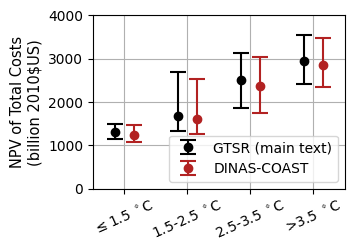

In [70]:
fig,ax = plt.subplots(1,1,figsize=(3.25,2.25))
plt.errorbar(x=[-.15,.85,1.85,2.85], y=npv_heights, 
             yerr=[npv_heights-npv_lowers, npv_uppers-npv_heights],
             fmt='o', color="black", elinewidth=1.5, capsize=6, capthick=1.5, label="GTSR (main text)")
plt.errorbar(x=[.15,1.15,2.15,3.15], y=npv_heights2, 
             yerr=[npv_heights2-npv_lowers2, npv_uppers2-npv_heights2],
             fmt='o', color="firebrick", elinewidth=1.5, capsize=6, capthick=1.5, label="DINAS-COAST")
plt.axis([-0.5,3.5,0,4000]); plt.ylabel("NPV of Total Costs\n(billion 2010$US)", fontsize=10.5)
plt.xticks(ticks=[0,1,2,3], labels=threshold_labels, rotation=24, fontsize=10); plt.yticks(fontsize=10)
plt.grid(); ax.set_axisbelow(True); plt.legend()
fig.savefig("./figures/npv_global_errorbars-only_Darnell_SOM-DCsurge.pdf", bbox_inches='tight');